# Задача об переворачивании математического маятника
в статье, приведенной мне по ссылке: https://www.gymlibrary.ml/environments/classic_control/pendulum/?highlight=pendulum, не уточняется какой именно маятник,
но пусть он будет математическим с начльными условиями:
$l = 1, m = 1, \theta_1 = \theta_0, \omega_1 =\omega_0 $
Задача состоит в том, что бы перевернуть его в верхнее положение и удерживать его там. Для удобства будем считать, что точка отсчета угла находится внизу окружности, описываемой маятником.
Для этого воспользуемся PID регулятором: Коэффициенты подберем с точностью $\epsilon = 0.1$



Уравнения:

$ml^2\ddot{\theta} + mglsin(\theta) = u \newline
\left\{ \begin{gathered}
\dot{\theta}_0 = \theta_1\\
\dot{\theta}_1 = \frac{u - mglsin(\theta_0)}{l^2m}
\end{gathered}  \right.$

In [329]:
#Начальное значение
from math import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt




class Params:

    def __init__(self):

        self.m = 1
        self.l = 1
        self.g = 9.8


In [330]:


def rhs(t, th, p, u):
    
    dthdt = np.zeros(2)
    dthdt[0] = th[1]
    dthdt[1] = (u - p.m*p.g*p.l*(sin(th[0])))/(p.l**2*p.m)
    
    return dthdt


In [331]:
class PID_Controller():
    def __init__(self, dt, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integral = 0
        self.e_prev = None

    def update(self, state, reference):
        error = state - reference
        if self.e_prev is None:
            dedt = 0
        else:
            # первый порядок апроксимации
            dedt = (error - self.e_prev) / self.dt
        
        self.integral = self.integral + error * self.dt
        
        self.e_prev = error
        return self.kp * error + self.ki * self.integral + self.kd * dedt


In [332]:


# Решатель
def solve(t0, tf, dt, th0, p, pid1):
    time = np.arange(t0, tf, dt)
    result = th0
    force = []
    
    for i in range(len(time) - 1):
    
        u = -pid1.update(th0[0], pi)
        force = np.append(force, u)
        solution = solve_ivp(lambda t, th: rhs(t, th, p, u), (time[i], time[i + 1]), th0)
        th0 = solution.y[:, -1]
    
        result = np.vstack((result, th0))
    
    return time, force, result

In [333]:
t_0 = 0
t_f = 100
d_t = 0.01
init = [1., 1.]
param = Params()

pid1 = PID_Controller(d_t, 30, 10, 8)


[t, f, theta] = solve(t_0, t_f, d_t, init, param, pid1)

-2.141592653589793
-2.128782879209954
-2.1108794326230873
-2.0886324297902887
-2.0624695523893726
-2.032785398646811
-1.9999540634301889
-1.9643297252564338
-1.9262467787649753
-1.886020016754185
-1.8439448836721155
-1.800297800125756
-1.7553365558083986
-1.7093007670776492
-1.662412394417545
-1.6148763141630116
-1.5668809381660571
-1.5185988745527286
-1.470187622365331
-1.4217902927070285
-1.3735363490003183
-1.325542359125392
-1.2779127525021585
-1.2307405755997276
-1.1841082398759435
-1.1380882567424742
-1.092743954793575
-1.0481301752058236
-1.0042939418909334
-0.9612751036459741
-0.9191069461798689
-0.8778167724899943
-0.8374264506092945
-0.7979529282367084
-0.7594087141986403
-0.7218023270656766
-0.6851387115676308
-0.6494196237136043
-0.61464398573546
-0.5808082121371325
-0.5479065082531371
-0.51593114280239
-0.48487269597289107
-0.45472028459370595
-0.42546176594757545
-0.3970839217545459
-0.36957262381813427
-0.34291298277412263
-0.31708948132119197
-0.29208609324486456
-0.267

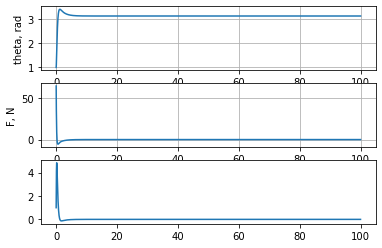

In [334]:


ax = plt.subplot(3,1,1)

ax.plot(t, theta[:, 0])
ax.set_xlabel('t, sec')
ax.set_ylabel('theta, rad')
ax.grid()


ax = plt.subplot(3, 1, 2)
ax.plot(t[0:-1], f)
ax.set_xlabel('t, sec')
ax.set_ylabel('F, N')
ax.grid()
ax = plt.subplot(3,1,3)
ax.plot(t, theta[:,1])
plt.savefig("file1.jpeg")
